<a href="https://colab.research.google.com/github/evandrofr/visao_projeto2/blob/main/projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROJETO 2

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

Cubo 1


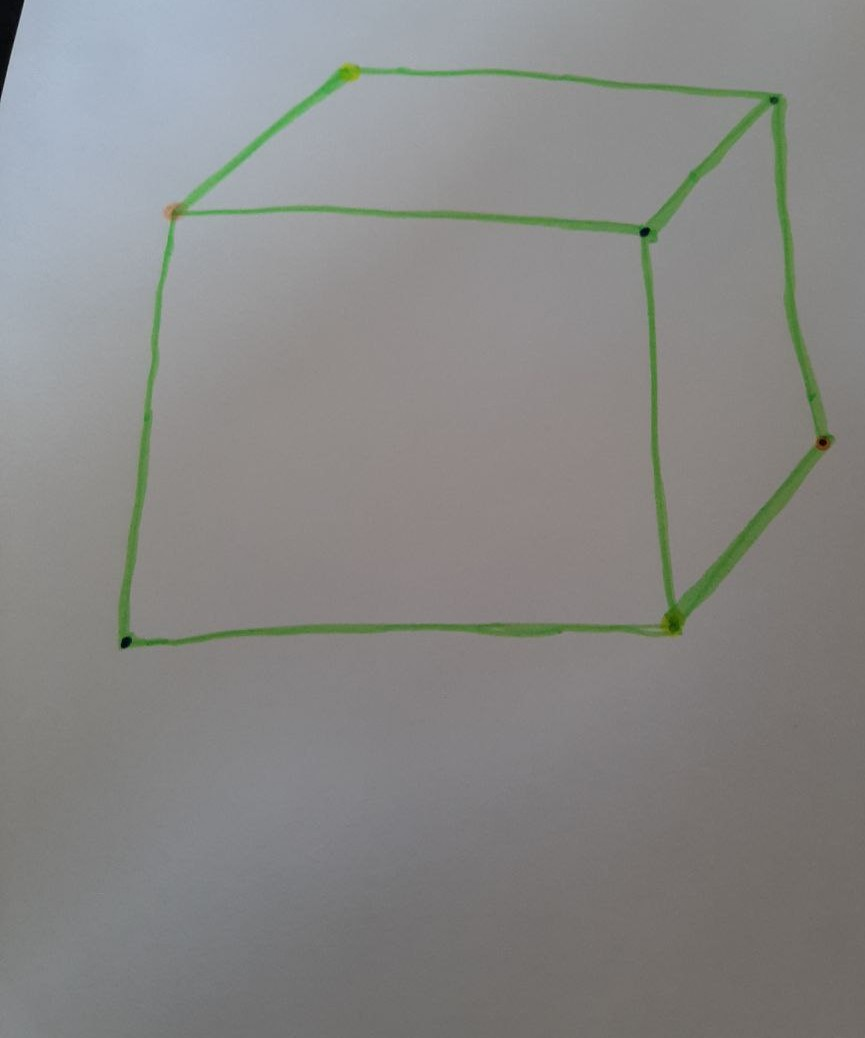

Cubo 2


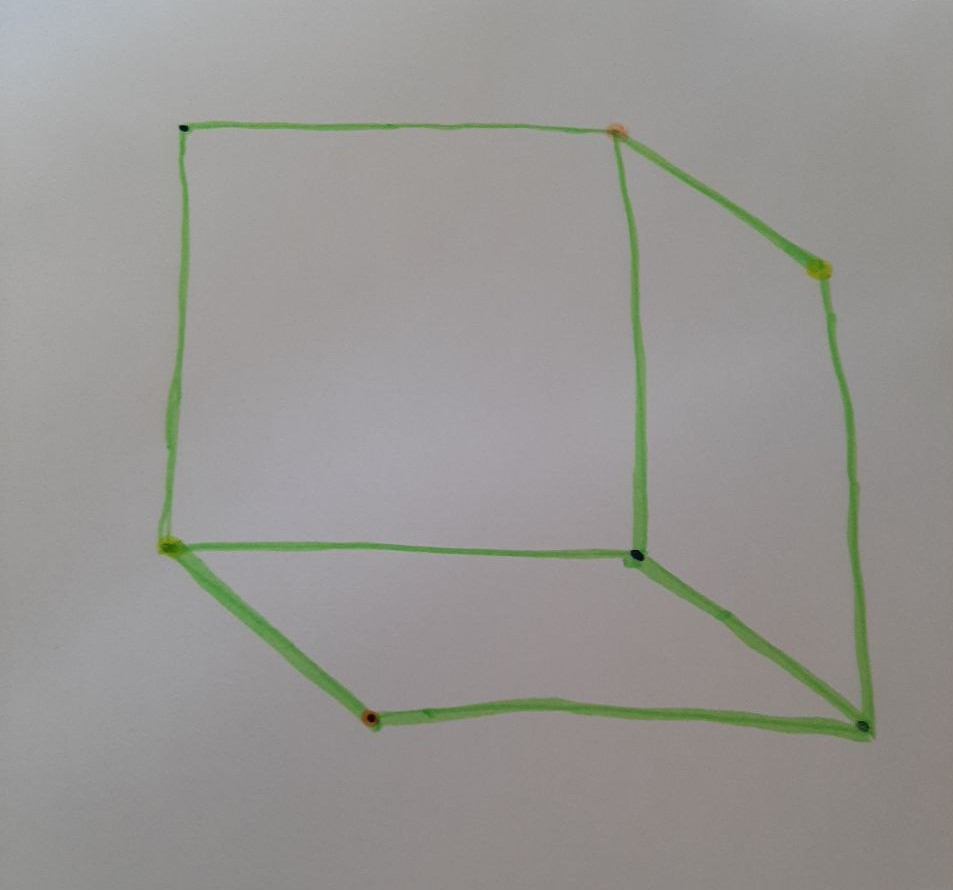

In [5]:
img1 = cv.imread('cubo_02.jpeg')
print("Cubo 1")
cv2_imshow(img1)
img2 = cv.imread('cubo_03.jpeg')
print("Cubo 2")
cv2_imshow(img2)

Todas as ocorrências:


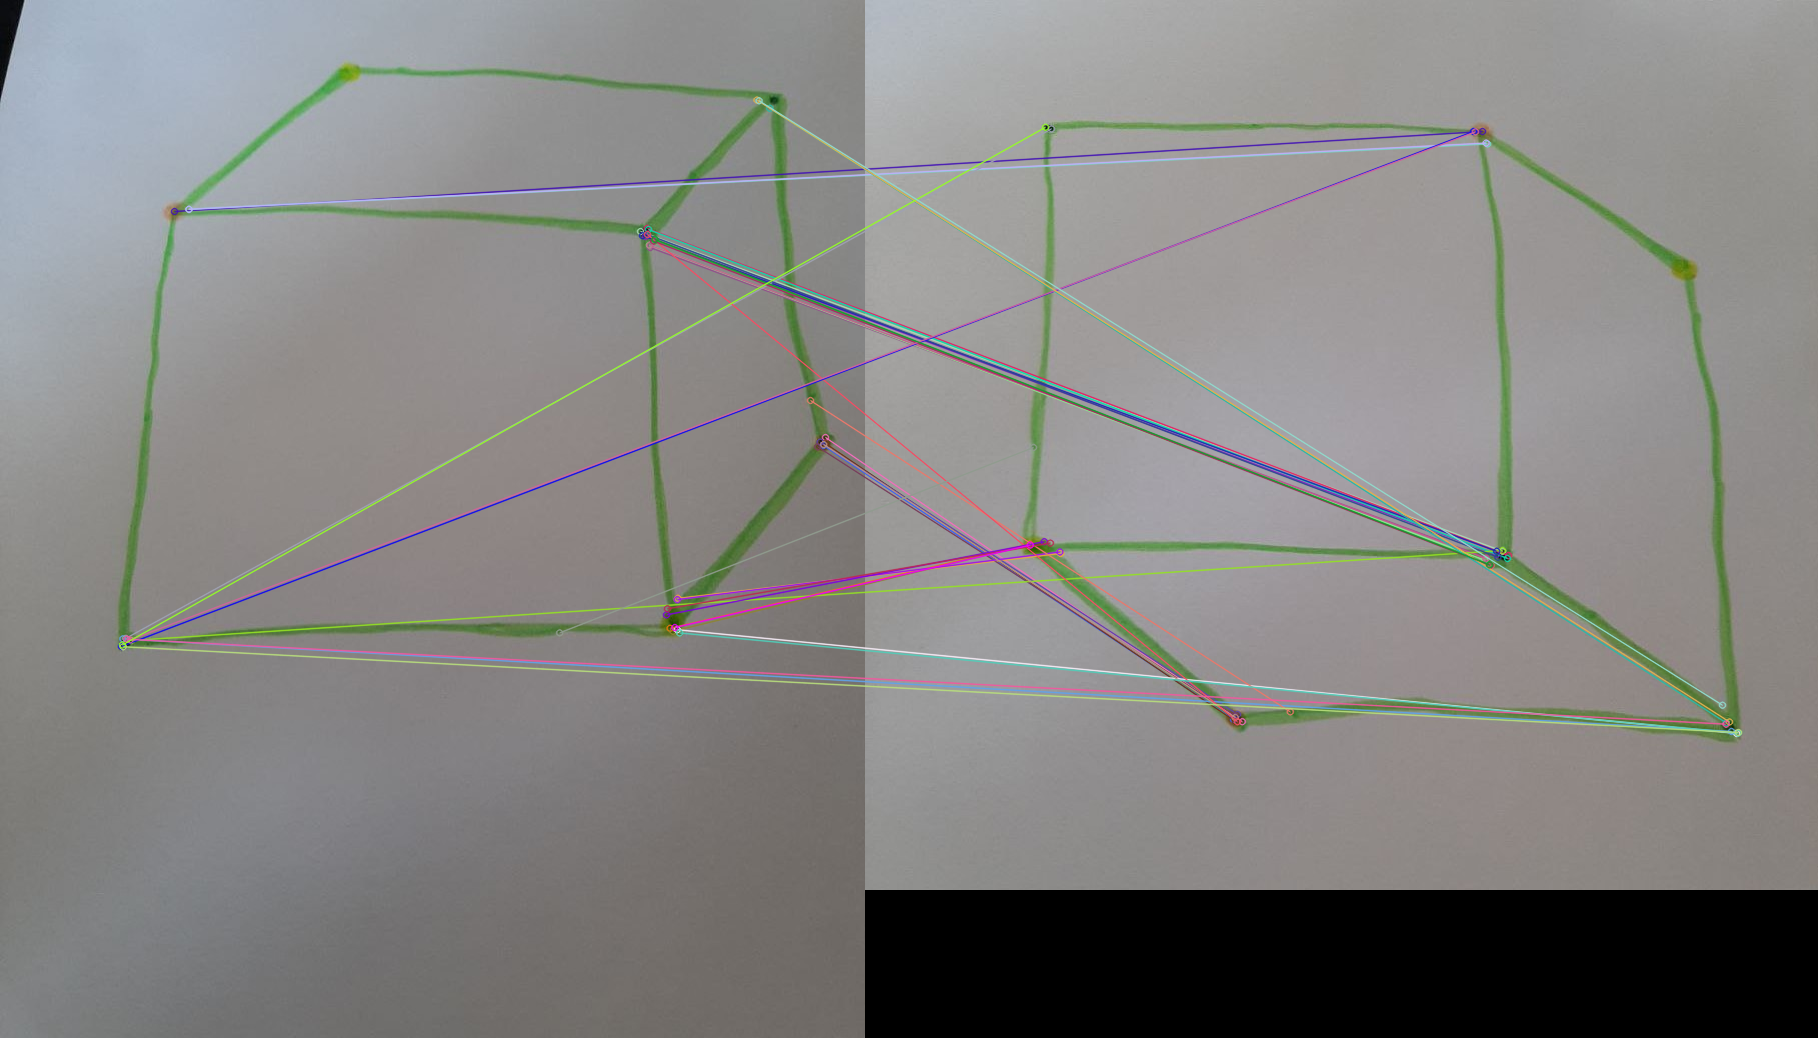

In [6]:
orb = cv.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
print("Todas as ocorrências:")
cv2_imshow(img3)

Somente as doze primeiras correspondências:
(777.0, 99.0) <--> (389.0, 125.0)
(771.0, 102.0) <--> (180.0, 127.0)
(777.0, 102.0) <--> (184.0, 131.0)
(774.0, 103.0) <--> (608.0, 131.0)
(772.0, 106.0) <--> (617.0, 131.0)
(189.0, 209.0) <--> (621.0, 143.0)
(174.0, 211.0) <--> (829.0, 276.0)
(644.0, 228.0) <--> (168.0, 447.0)
(648.0, 229.0) <--> (179.0, 541.0)
(640.0, 231.0) <--> (164.0, 544.0)
(647.0, 234.0) <--> (631.0, 548.0)
(645.0, 236.0) <--> (637.0, 550.0)


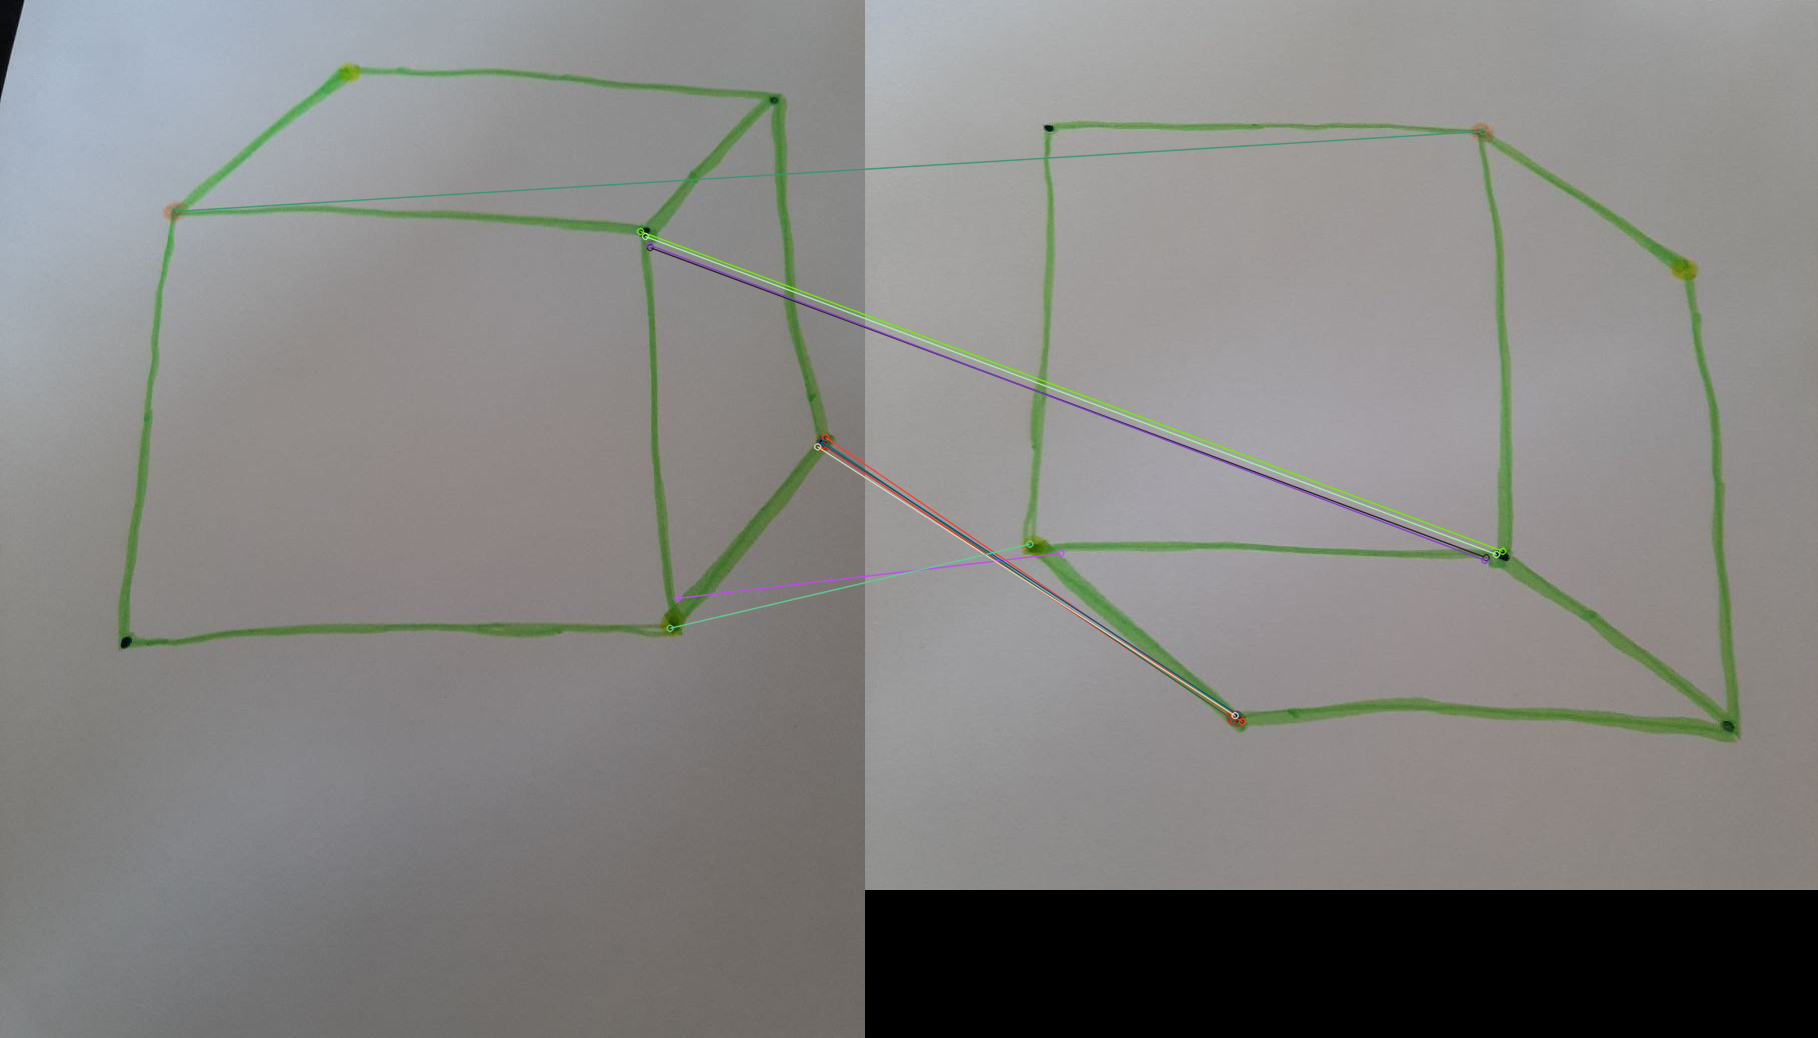

In [8]:
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:12],None, flags=2)
print("Somente as doze primeiras correspondências:")
for i in range(12):
  print(kp1[i].pt,"<-->",kp2[i].pt)
cv2_imshow(img3)

### Percebesse que os pontos encontrados sempre são próximos aos vertices